In [1]:
import os
import torch
import pytorch_lightning as pl
import pandas as pd
from tqdm.auto import tqdm
import math
import librosa
import cv2
import torch.nn as nn
from metric import score

/data/yaz/birdclef24/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create Dataset and melspecs

In [2]:
from config import Config
    
config = Config()

print('fix seed')
pl.seed_everything(config.SEED, workers=True)

Seed set to 42


fix seed


42

In [3]:
# labels
label_list = sorted(os.listdir(os.path.join(config.DATA_ROOT, 'train_audio')))
label_id_list = list(range(len(label_list)))
label2id = dict(zip(label_list, label_id_list))
id2label = dict(zip(label_id_list, label_list))

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using', torch.cuda.device_count(), 'GPU(s)')

Using 1 GPU(s)


## Preprocess

In [5]:
metadata_df = pd.read_csv(f'{config.DATA_ROOT}/train_metadata.csv')
metadata_df.head()

primary_label secondary_labels      type  latitude  longitude  \
0        asbfly               []  ['call']   39.2297   118.1987   
1        asbfly               []  ['song']   51.4030   104.6401   
2        asbfly               []  ['song']   36.3319   127.3555   
3        asbfly               []  ['call']   21.1697    70.6005   
4        asbfly               []  ['call']   15.5442    73.7733   

      scientific_name             common_name  \
0  Muscicapa dauurica  Asian Brown Flycatcher   
1  Muscicapa dauurica  Asian Brown Flycatcher   
2  Muscicapa dauurica  Asian Brown Flycatcher   
3  Muscicapa dauurica  Asian Brown Flycatcher   
4  Muscicapa dauurica  Asian Brown Flycatcher   

                              author  \
0                     Matt Slaymaker   
1                   Magnus Hellström   
2                      Stuart Fisher   
3                          vir joshi   
4  Albert Lastukhin & Sergei Karpeev   

                                             license  rating  \
0  Creative Commons Attribution-NonCommercial-Sha...     5.0   
1  Creative Commons Attribution-NonCommercial-Sha...     2.5   
2  Creative Commons Attribution-NonCommercial-Sha...     2.5   
3  Creative Commons Attribution-NonCommercial-Sha...     4.0   
4  Creative Commons Attribution-NonCommercial-Sha...     4.0   

                                 url             filename  
0  https://www.xeno-canto.org/134896  asbfly/XC134896.ogg  
1  https://www.xeno-canto.org/164848  asbfly/XC164848.ogg  
2  https://www.xeno-canto.org/175797  asbfly/XC175797.ogg  
3  https://www.xeno-canto.org/207738  asbfly/XC207738.ogg  
4  https://www.xeno-canto.org/209218  asbfly/XC209218.ogg

In [6]:
train_df = metadata_df[['primary_label', 'rating', 'filename']].copy()

# create target
train_df['target'] = train_df.primary_label.map(label2id)
# create filepath
train_df['filepath'] = config.DATA_ROOT + '/train_audio/' + train_df.filename
# create new sample name
train_df['samplename'] = train_df.filename.map(lambda x: x.split('/')[0] + '-' + x.split('/')[-1].split('.')[0])

print(f'{len(train_df)} samples')

train_df.head()

24459 samples


primary_label  rating             filename  target  \
0        asbfly     5.0  asbfly/XC134896.ogg       0   
1        asbfly     2.5  asbfly/XC164848.ogg       0   
2        asbfly     2.5  asbfly/XC175797.ogg       0   
3        asbfly     4.0  asbfly/XC207738.ogg       0   
4        asbfly     4.0  asbfly/XC209218.ogg       0   

                                            filepath       samplename  
0  /data/yaz/birdclef24/data/train_audio/asbfly/X...  asbfly-XC134896  
1  /data/yaz/birdclef24/data/train_audio/asbfly/X...  asbfly-XC164848  
2  /data/yaz/birdclef24/data/train_audio/asbfly/X...  asbfly-XC175797  
3  /data/yaz/birdclef24/data/train_audio/asbfly/X...  asbfly-XC207738  
4  /data/yaz/birdclef24/data/train_audio/asbfly/X...  asbfly-XC209218

In [7]:
import numpy as np
import scipy as sci

def ogg2spec_via_scipy(audio_data):
    # handles NaNs
    mean_signal = np.nanmean(audio_data)
    audio_data = np.nan_to_num(audio_data, nan=mean_signal) if np.isnan(audio_data).mean() < 1 else np.zeros_like(audio_data)

    # to spec.
    frequencies, times, spec_data = sci.signal.spectrogram(
        audio_data, 
        fs=config.FS, 
        nfft=config.N_FFT, 
        nperseg=config.WIN_SIZE, 
        noverlap=config.WIN_LAP, 
        window='hann'
    )
    
    # Filter frequency range
    valid_freq = (frequencies >= config.MIN_FREQ) & (frequencies <= config.MAX_FREQ)
    spec_data = spec_data[valid_freq, :]
    
    # Log
    spec_data = np.log10(spec_data + 1e-20)
    
    # min/max normalize
    spec_data = spec_data - spec_data.min()
    spec_data = spec_data / spec_data.max()
    
    return spec_data

In [8]:
import torchaudio
import IPython.display as ipd
audio_data, sr = torchaudio.load("/data/yaz/birdclef24/data/train_audio/asbfly/XC49755.ogg")

In [9]:
ipd.Audio(audio_data, rate=sr)

In [10]:
if config.LOAD_DATA:
    print('load from file')
    all_bird_data = np.load(f'{config.PREPROCESSED_DATA_ROOT}/spec_first_5sec_256_256.npy', allow_pickle=True).item()
else:
    all_bird_data = dict()
    for i, row_metadata in tqdm(train_df.iterrows(), total=train_df.shape[0]):

        # load ogg
        audio_data, _ = librosa.load(row_metadata.filepath, sr=config.FS)

        # crop
        n_copy = math.ceil(5 * config.FS / len(audio_data))
        if n_copy > 1: audio_data = np.concatenate([audio_data]*n_copy)

        # start_idx = int(len(audio_data) / 2 - 2.5 * config.FS)
        start_idx = 0
        end_idx = int(start_idx + 5.0 * config.FS)
        input_audio = audio_data[start_idx:end_idx]

        # ogg to spec.
        input_spec = ogg2spec_via_scipy(input_audio)
        
        input_spec = cv2.resize(input_spec, (256, 256), interpolation=cv2.INTER_AREA)

        all_bird_data[row_metadata.samplename] = input_spec.astype(np.float32)

    # save to file
    np.save(os.path.join(config.OUTPUT_DIR, f'spec_first_5sec_256_256.npy'), all_bird_data)

load from file


## Model

In [11]:
import timm

In [12]:
class EffNet(nn.Module):
    def __init__(self, model_name="efficientnet_b0", num_classes=None) -> None:
        super().__init__()

        self.model = timm.create_model(
            model_name, 
            pretrained=True, 
            in_chans=1, 
            num_classes=num_classes
        )
    
    def forward(self, x):
        # [B, W, H] -> [B, 1, W, H]
        x = x.unsqueeze(1)
        x = self.model(x)

        return x

## Dataset

In [13]:
class BirdDataset(torch.utils.data.Dataset):
    
    def __init__(
        self,
        metadata,
        augmentation=None,
        mode='train'
    ):
        super().__init__()
        self.metadata = metadata
        self.augmentation = augmentation
        self.mode = mode
    
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, index):
        
        row_metadata = self.metadata.iloc[index]
        
        # load spec. data
        input_spec = all_bird_data[row_metadata.samplename]
        
        # aug
        if self.augmentation is not None:
            input_spec = self.augmentation(image=input_spec)['image']
        
        # target
        target = row_metadata.target
        
        return torch.tensor(input_spec, dtype=torch.float32), torch.tensor(target, dtype=torch.long)

In [14]:
import gc
import matplotlib.pyplot as plt

In [15]:
dummy_dataset = BirdDataset(train_df)

test_input, test_target = dummy_dataset[0]
print(test_input.detach().numpy().shape)


(256, 256)


In [16]:
def show_batch(ds, row=3, col=3):
    fig = plt.figure(figsize=(10, 10))
    img_index = np.random.randint(0, len(ds)-1, row*col)
    
    for i in range(len(img_index)):
        img, label = dummy_dataset[img_index[i]]
        
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        
        ax = fig.add_subplot(row, col, i + 1, xticks=[], yticks=[])
        ax.imshow(img, cmap='jet')
        ax.set_title(f'ID: {img_index[i]}; Target: {label}')
    
    plt.tight_layout()
    plt.show()

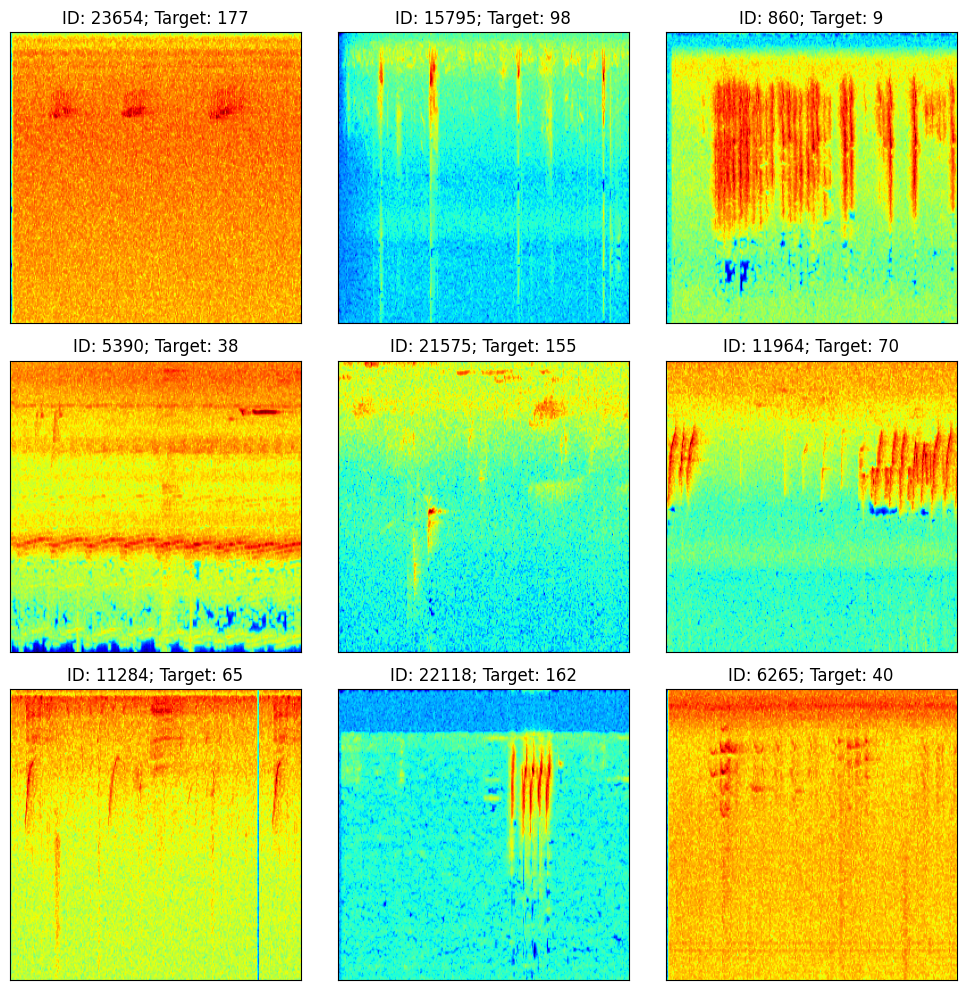

17832

In [17]:

if config.VISUALIZE:
    show_batch(dummy_dataset)

del dummy_dataset
gc.collect()

## Training pipeline

In [18]:
class BirdModel(pl.LightningModule):
    
    def __init__(self):
        super().__init__()
        
        # == backbone ==
        self.backbone = EffNet(num_classes=len(label_list))
        
        # == loss function ==
        self.loss_fn = nn.CrossEntropyLoss()
        
        # == record ==
        self.validation_step_outputs = []
        
    def forward(self, images):
        return self.backbone(images)
    
    def configure_optimizers(self):
        
        # == define optimizer ==
        model_optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.parameters()),
            lr=config.LR,
            weight_decay=config.WEIGHT_DECAY
        )
        
        # == define learning rate scheduler ==
        # lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            model_optimizer,
            T_0=config.EPOCHS,
            T_mult=1,
            eta_min=1e-6,
            last_epoch=-1
        )
        
        return {
            'optimizer': model_optimizer,
            'lr_scheduler': {
                'scheduler': lr_scheduler,
                'interval': 'epoch',
                'monitor': 'val_loss',
                'frequency': 1
            }
        }
    
    def training_step(self, batch, batch_idx):
        
        # == obtain input and target ==
        image, target = batch
        image = image.to(self.device)
        target = target.to(self.device)
        
        # == pred ==
        y_pred = self(image)
        
        # == compute loss ==
        train_loss = self.loss_fn(y_pred, target)
        
        # == record ==
        self.log('train_loss', train_loss, True)
        
        return train_loss
    
    def validation_step(self, batch, batch_idx):
        
        # == obtain input and target ==
        image, target = batch
        image = image.to(self.device)
        target = target.to(self.device)
        
        # == pred ==
        with torch.no_grad():
            y_pred = self(image)
            
        self.validation_step_outputs.append({"logits": y_pred, "targets": target})
        
    def train_dataloader(self):
        return self._train_dataloader

    def validation_dataloader(self):
        return self._validation_dataloader
    
    def on_validation_epoch_end(self):
        
        # = merge batch data =
        outputs = self.validation_step_outputs
        
        output_val = nn.Softmax(dim=1)(torch.cat([x['logits'] for x in outputs], dim=0)).cpu().detach()
        target_val = torch.cat([x['targets'] for x in outputs], dim=0).cpu().detach()
        
        # = compute validation loss =
        val_loss = self.loss_fn(output_val, target_val)
        
        # target to one-hot
        target_val = torch.nn.functional.one_hot(target_val, len(label_list))
        
        # = val with ROC AUC =
        gt_df = pd.DataFrame(target_val.numpy().astype(np.float32), columns=label_list)
        pred_df = pd.DataFrame(output_val.numpy().astype(np.float32), columns=label_list)
        
        gt_df['id'] = [f'id_{i}' for i in range(len(gt_df))]
        pred_df['id'] = [f'id_{i}' for i in range(len(pred_df))]
        
        val_score = score(gt_df, pred_df, row_id_column_name='id')
        
        self.log("val_score", val_score, True)
        
        # clear validation outputs
        self.validation_step_outputs = list()
        
        return {'val_loss': val_loss, 'val_score': val_score}

In [19]:
def predict(data_loader, model):
    model.to(config.DEVICE)
    model.eval()
    predictions = []
    gts = []
    for batch in tqdm(data_loader):
        with torch.no_grad():
            x, y = batch
            x = x.cuda()
            outputs = model(x)
            outputs = nn.Softmax(dim=1)(outputs)
        predictions.append(outputs.detach().cpu())
        gts.append(y.detach().cpu())
    
    predictions = torch.cat(predictions, dim=0).cpu().detach()
    gts = torch.cat(gts, dim=0).cpu().detach()
    gts = torch.nn.functional.one_hot(gts, len(label_list))
    
    return predictions.numpy().astype(np.float32), gts.numpy().astype(np.float32)

In [20]:
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar

In [21]:
def run_training(fold_id, total_df):
    print('================================================================')
    print(f"==== Running training for fold {fold_id} ====")
    
    # == create dataset and dataloader ==
    train_df = total_df[total_df['fold'] != fold_id].copy()
    valid_df = total_df[total_df['fold'] == fold_id].copy()
    
    print(f'Train Samples: {len(train_df)}')
    print(f'Valid Samples: {len(valid_df)}')
    
    train_ds = BirdDataset(train_df, mode='train')
    val_ds = BirdDataset(valid_df, mode='valid')
    
    train_dl = torch.utils.data.DataLoader(
        train_ds,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=config.N_WORKERS,
        pin_memory=True,
        persistent_workers=True
    )
    
    val_dl = torch.utils.data.DataLoader(
        val_ds,
        batch_size=config.BATCH_SIZE * 2,
        shuffle=False,
        num_workers=config.N_WORKERS,
        pin_memory=True,
        persistent_workers=True
    )
    
    # == init model ==
    bird_model = BirdModel()
    
    # == init callback ==
    checkpoint_callback = ModelCheckpoint(monitor='val_score',
                                          dirpath=config.OUTPUT_DIR,
                                          save_top_k=1,
                                          save_last=False,
                                          save_weights_only=True,
                                          filename=f"fold_{fold_id}",
                                          mode='max')
    callbacks_to_use = [checkpoint_callback, TQDMProgressBar(refresh_rate=1)]
    
    # == init trainer ==
    trainer = pl.Trainer(
        max_epochs=config.EPOCHS,
        val_check_interval=0.5,
        callbacks=callbacks_to_use,
        enable_model_summary=False,
        accelerator="gpu",
        deterministic=True,
        precision='16-mixed' if config.MIXED_PRECISION else 32,
    )
    
    # == Training ==
    trainer.fit(bird_model, train_dataloaders=train_dl, val_dataloaders=val_dl)
    
    # == Prediction ==
    best_model_path = checkpoint_callback.best_model_path
    weights = torch.load(best_model_path)['state_dict']
    bird_model.load_state_dict(weights)
    
    preds, gts = predict(val_dl, bird_model)
    
    # = create dataframe =
    pred_df = pd.DataFrame(preds, columns=label_list)
    pred_df['id'] = np.arange(len(pred_df))
    gt_df = pd.DataFrame(gts, columns=label_list)
    gt_df['id'] = np.arange(len(gt_df))
    
    # = compute score =
    val_score = score(gt_df, pred_df, row_id_column_name='id')
    
    # == save to file ==
    pred_cols = [f'pred_{t}' for t in label_list]
    valid_df = pd.concat([valid_df.reset_index(), pd.DataFrame(np.zeros((len(valid_df), len(label_list)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)
    valid_df[label_list] = gts
    valid_df[pred_cols] = preds
    valid_df.to_csv(f"{config.OUTPUT_DIR}/pred_df_f{fold_id}.csv", index=False)
    
    return preds, gts, val_score

In [22]:
from sklearn.model_selection import KFold

In [24]:
kf = KFold(n_splits=config.FOLDS, shuffle=True, random_state=config.SEED)
train_df['fold'] = 0
for fold, (train_idx, val_idx) in enumerate(kf.split(train_df)):
    train_df.loc[val_idx, 'fold'] = fold

In [25]:
# training
torch.set_float32_matmul_precision('high')

# record
fold_val_score_list = list()
oof_df = train_df.copy()
pred_cols = [f'pred_{t}' for t in label_list]
oof_df = pd.concat([oof_df, pd.DataFrame(np.zeros((len(oof_df), len(pred_cols)*2)).astype(np.float32), columns=label_list+pred_cols)], axis=1)

for f in range(config.FOLDS):
    
    # get validation index
    val_idx = list(train_df[train_df['fold'] == f].index)
    
    # main loop of f-fold
    val_preds, val_gts, val_score = run_training(f, train_df)
    
    # record
    oof_df.loc[val_idx, label_list] = val_gts
    oof_df.loc[val_idx, pred_cols] = val_preds
    fold_val_score_list.append(val_score)
    
    # # only training one fold
    # break


for idx, val_score in enumerate(fold_val_score_list):
    print(f'Fold {idx} Val Score: {val_score:.5f}')

# oof_gt_df = oof_df[['samplename'] + label_list].copy()
# oof_pred_df = oof_df[['samplename'] + pred_cols].copy()
# oof_pred_df.columns = ['samplename'] + label_list
# oof_score = score(oof_gt_df, oof_pred_df, 'samplename')
# print(f'OOF Score: {oof_score:.5f}')

oof_df.to_csv(f"{config.OUTPUT_DIR}/oof_pred.csv", index=False)

==== Running training for fold 0 ====
Train Samples: 19567
Valid Samples: 4892


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/yaz/birdclef24/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Missing logger folder: /data/yaz/birdclef24/baseline/lightning_logs
/data/yaz/birdclef24/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /data/yaz/birdclef24/out exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0:  23%|██▎       | 35/153 [00:06<00:22,  5.16it/s, v_num=0, train_loss=3.530]

/data/yaz/birdclef24/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


FileNotFoundError: [Errno 2] No such file or directory: ''